## Ads Conversion Analysis

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).

I'm going to predict conversion rate and come up with recommendations for the product team and the marketing team to
improve conversion rate.

In [2]:
import os, glob
import pandas as pd
os.chdir("D:/takehome_challenge/Conversion_Rate")

In [3]:
conversion = pd.read_csv('conversion_data.csv')

## Basic Investigation and Anomaly Detection

In [3]:
conversion.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [6]:
conversion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


After observing the data, we need to find the abnormal data, if any.

In [7]:
conversion.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


The maximum of age is 123, which is kind of weird. And we can also see that the user of the product is pretty young.

The conversion rate is about 3%, which is compatible with industry standard.

In [8]:
conversion.groupby('country')['country'].count()

country
China       76602
Germany     13056
UK          48450
US         178092
Name: country, dtype: int64

In [9]:
conversion.groupby('source')['source'].count()

source
Ads        88740
Direct     72420
Seo       155040
Name: source, dtype: int64

Most of the users are come from China and the major source is Ads.

In [13]:
#remove abnormal age data

sorted(conversion['age'], reverse = True)

# There are two abnormal ages: 123, 111. Let's check how many rows of data have these ages

conversion[(conversion['age'] == 123) | (conversion['age'] == 111)]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [15]:
# Since there are just two rows of data, let's just remove them

conversion = conversion.drop([90928, 295581])

As in the real world, there might be some bugs within logging codes of engineering team if there are enormous weird data. If that's the case, I will discuss with them and try to figure out what happened.

## Further Investigation

In [16]:
conversion.groupby('country').agg({'converted':'mean'})

,converted
country,
China,0.001332
Germany,0.062428
UK,0.052612
US,0.037801


In [17]:
conversion.groupby('source').agg({'converted':'mean'})

,converted
source,
Ads,0.034472
Direct,0.028169
Seo,0.032888


In [19]:
conversion.groupby('new_user').agg({'converted':'mean'})

,converted
new_user,
0,0.071983
1,0.014021


In [23]:
conversion.groupby('total_pages_visited').agg({'converted':'mean'}).apply(lambda x: x.sort_values(ascending = False))

,converted
total_pages_visited,
29,1.000000
28,1.000000
27,1.000000
26,1.000000
25,1.000000
24,1.000000
23,1.000000
22,1.000000
21,1.000000


In [24]:
conversion.groupby('age').agg({'converted':'mean'}).apply(lambda x: x.sort_values(ascending = False))

,converted
age,
17,0.071607
18,0.066029
19,0.058616
20,0.057109
21,0.053985
22,0.053243
23,0.047990
24,0.045448
26,0.039767


*We can also use plot to show trends here.

### Findings
1. Most of the users are in China, while the conversion rate is the lowest.
2. The conversion rate in different sources are the same.
3. Old user are more likely to convert. There might be some issue within the product that is not attractive for new user.
4. The more pages viewed, the more possibility a user will convert.
5. Young people are more likely to convert.

## Model Fitting

I will pick random forest classifier, which usually requires very little time to optimize it (its default params are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. 

Since SKlearn only accept numeric features, I need to convert country and source into numeric numbers

In [29]:
columns = ['country','source']
conversion = pd.get_dummies(conversion, columns = columns, drop_first = True)

In [30]:
conversion

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,1,0,0
316196,27,1,6,0,0,0,1,1,0
316197,25,0,4,0,0,0,0,0,0
316198,22,0,4,0,0,0,1,0,1


In [31]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics #accuracy measure
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 

In [32]:
train, test = train_test_split(conversion, test_size = 0.3, random_state = 0, stratify = conversion['converted'])
train_x = train.drop(['converted'], axis = 1)
train_y = train['converted']
test_x = test.drop(['converted'], axis = 1)
test_y = test['converted']
x = conversion.drop(['converted'], axis = 1)
y = conversion['converted']

In [35]:

model = RandomForestClassifier(oob_score = True)
model.fit(train_x, train_y)
predict = model.predict(test_x)
#test accuracy
accuracy = metrics.accuracy_score(predict, test_y)
accuracy

0.984303183639047

In [36]:
model.oob_score_

0.9844807488998726

In [13]:
fold = KFold(n_splits = 10, shuffle = True, random_state = 0)
cv_result = cross_val_score(model,x,y, cv = fold, scoring = 'accuracy')
cv_result

array([0.98387097, 0.98425047, 0.98450348, 0.98434535, 0.98504111,
       0.98462998, 0.98760278, 0.98383934, 0.98494624, 0.98472486])

The model is fitted very well without overfitting. Let's go head doing more about feature importance and partial dependency plot

In [37]:
model.feature_importances_

array([0.10951367, 0.03991976, 0.80843151, 0.00834451, 0.01167462,
       0.01280023, 0.00436674, 0.00494895])

As we can see, total_pages_visited (0.808) is the most important feature in this model. However. it is not actionable. This is not what production team can control. Let's remove this powerful feature and see if we can find more.

In [39]:
model_1 = RandomForestClassifier(oob_score = True)
model_1.fit(train_x.drop('total_pages_visited', axis = 1), train_y)
predict_1 = model_1.predict(test_x.drop('total_pages_visited', axis = 1))
#test accuracy
accuracy_1 = metrics.accuracy_score(predict_1, test_y)
accuracy_1

0.96775247733502

In [40]:
model_1.oob_score_

0.9677280900703901

In [41]:
model_1.feature_importances_

array([0.29767048, 0.40650269, 0.06402538, 0.104717  , 0.10699092,
       0.0130874 , 0.00700612])

Now the most important feature is new_user! So our team may need to focus more on our new acquired ones.

In [42]:
from sklearn.inspection import plot_partial_dependence

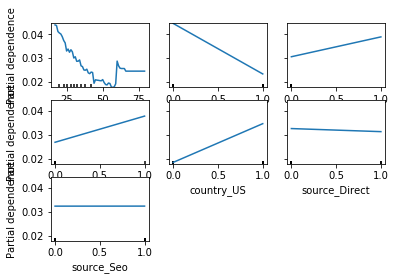

In [43]:
features = ['age','new_user','country_Germany','country_UK','country_US','source_Direct','source_Seo']
plot_partial_dependence(model, train_x, features)

### Findings

1. Young people did really well in retention
2. Sources really don't matter
3. Old users are tend to convert

## Some conclusions and suggestions:

1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use
marketing channel which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that
there are few Germans coming to the site: way less than UK, despite a larger population. Again,
marketing should get more Germans. Big opportunity.
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site
could be a good idea to try.
4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the
local culture, some payment issue or maybe it is just in English! Given how many users are based in
China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion
clearly starts dropping.
6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high
purchase intent. I could email her targeted offers or sending her reminders. Overall, these are
probably the easiest users to make convert.